<a href="https://colab.research.google.com/github/Shubhamd13/NLP/blob/main/6_1_KL_Divergence_vs_CE_Student_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
SEED = 42
np.random.seed(SEED)
np.set_printoptions(precision=2, suppress=True)

# Vocabulary

In [2]:
vocab = ["mat", "the", "on", "cat", "sat"]
word_to_index = {word: i for i, word in enumerate(vocab)}

vocab_size = len(vocab)
embedding_dim = 4

np.random.seed(SEED)
embeddings = np.random.randn(vocab_size, embedding_dim)  # Token Embeddings

# Decoder

To keep things simple, we will use a basic decoder architecture that follows this flow:

$
\text{Input Embedding} \rightarrow \text{Self-Attention} \rightarrow \text{Residual Connection & LayerNorm} → \text{Linear Projection to Vocabulary} \rightarrow \text{Loss Calculation}
$

We are skipping some of the usual components like MLP layers, Cross-Attention for simplicity.

# Step 1. Input Embedding

In [3]:
input_sentence = "the cat sat on"
input_tokens = input_sentence.split()

print(input_tokens)
seq_len = len(input_tokens)

input_indices = [word_to_index[word] for word in input_tokens]
input_embedding = embeddings[input_indices]

['the', 'cat', 'sat', 'on']


# Step 2. Self Attention Calculation

$\textbf{Step a. Query, Key, and Value Computation:}$

$Q = X W_Q, \quad K = X W_K, \quad V = X W_V$

$\textbf{Step b. Attention Scores:}$

$\text{Attention Scores} = \frac{Q K^T}{\sqrt{d}}$

$\textbf{Step c. Causal Masking:}$

To enforce causal attention (only attending to past and current tokens), we apply a causal mask \( M \) to the attention scores matrix. The causal mask is defined as:

$ M_{ij} =
\begin{cases}
-\infty & \text{if } j > i \\
0 & \text{otherwise}
\end{cases}
$

The attention scores are updated by adding the mask:

$\text{Masked Attention Scores} = \text{Attention Scores} + M$

$\textbf{Step d. Softmax:}$

$\text{Attention Weights} = \text{Softmax}(\text{Masked Attention Scores})$

$\textbf{Step e. Weighted Sum of Values:}$

$\text{Attention Output} = \text{Attention Weights} \cdot V$

$\textbf{Final Formula:}$

$
\text{Attention Output} = \text{Softmax}\left( \frac{Q K^T}{\sqrt{d}} + M \right) \cdot V$

$\textbf{Formula for Softmax:}$

$softmax(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{K} e^{x_j}}$

In [4]:
np.random.seed(SEED)

def softmax(x):
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=-1, keepdims=True)

def self_attention(x):

    # random weight matrices for Q, K, V
    W_q = np.random.randn(embedding_dim, embedding_dim)
    W_k = np.random.randn(embedding_dim, embedding_dim)
    W_v = np.random.randn(embedding_dim, embedding_dim)

    # a. Calculate Q, K, V matrices
    Q = x @ W_q
    K = x @ W_k
    V = x @ W_v

    # b. Scaled attention scores
    scores = Q @ K.T / np.sqrt(embedding_dim)

    # c. Causal Attention Masking
    causal_mask = []
    for i in range(seq_len):
        row = []
        for j in range(seq_len):
            if j > i:
                row.append(float('-inf'))  # block future tokens
            else:
                row.append(0.0) # allow current & past tokens
        causal_mask.append(row)
    causal_mask = np.array(causal_mask)

    # Apply Causal Mask to Attention Scores
    masked_attn_scores = scores + causal_mask

    # d. Apply softmax
    attn_weights = softmax(masked_attn_scores)

    # e. Calculate wighted sum values
    return attn_weights @ V

attention_output = self_attention(input_embedding)

# Step 3. Residual Connection & Layer Normalization

Formula for residual connection:

$ Z_{residual} = Input_{embedding}+Attention_{output} $

Formula for layer normalization:

$$
N(x) = \frac{x - \mu}{\alpha}
$$

$$
\mu = \frac{1}{H} \sum_{i=1}^{H} X_i
$$

$$
\alpha = \sqrt{ \frac{1}{H} \sum_{i=1}^{H} (x_i - \mu)^2 }
$$

Where:

- \( x \) = Vector representation of inputs  
- \( H \) = Number of inputs  
- \( \mu \) = Mean of inputs  
- \( \alpha \) = Standard deviation of inputs

In [5]:
np.random.seed(SEED)

def layer_norm(x):
    mean = x.mean(axis=-1, keepdims=True)
    std = x.std(axis=-1, keepdims=True)
    return (x - mean) / std

residual_conn = input_embedding + attention_output
decoder_output = layer_norm(residual_conn)

###<--- Write code here
                # print decoder output matrix
print(decoder_output)
###

[[-1.3  -0.64  0.83  1.1 ]
 [ 1.12 -0.57 -1.34  0.79]
 [-0.67  1.47  0.32 -1.13]
 [-0.68  1.57  0.14 -1.03]]


# Step 4. Projection to Vocabulary

Since we want to predict the next token, we need the embedding of the last output token.

Assume weight matrix for the linear layer: $𝑊_{out} ∈ 𝑅^{4×5}$ → here, embedding size = 4 and vocab size = 5

$logits = \text{embedding of last token} \; * \; W_{out} + bias$

In [6]:
np.random.seed(SEED)

def project_to_vocab(x):
    W_out = np.random.randn(embedding_dim, vocab_size)
    b_out = np.random.randn(vocab_size)
    return x @ W_out + b_out

final_token_rep = decoder_output[-1]  # Use the last token ("on") to predict next

###<--- Write code here
logits =  project_to_vocab(final_token_rep)         # function call to vocabulary projection
###

print(logits)

###<--- Write code here
pred_probs = softmax(logits)      # softmax over logits
###

print(pred_probs)

[ 1.27  3.32  0.54 -2.53  1.68]
[0.09 0.72 0.04 0.   0.14]


# Step 5. Set Soft and Hard Labels

In [7]:
# Hard label
hard_target_word = "mat"
hard_target_index = word_to_index[hard_target_word]

# Soft label - For simplicity we assume random proability distribution over the vocabulary
soft_target = np.array([0.6, 0.1, 0.1, 0.1, 0.1])  # 60% for "mat"

## Step 6. Cross Entropy Loss Calculation

If we are doing cross-entropy loss for predicting over 5 words (assume the vocabulary size is 5), the cross-entropy loss for a single prediction is -  


$\mathcal{L} = - \sum_{i=1}^{5} y_{i}\log(\hat{y}_{i})$

Here,

$y_{i}$ = 1 if word $i$ is the true label otherwise 0

$\hat{y}_{i}$ =  model’s predicted probability for word $i$

Because only one $y_{i}$ is 1 (true label), this simplifies to -

$\mathcal{L} = - \log(\hat{y})$

In [8]:
###<--- Write code here
ce_loss = -np.log(pred_probs[hard_target_index])             # cross entropy loss formula using hard target index
###

print(f"Cross Entropy Loss (hard): {ce_loss:.4f}")

Cross Entropy Loss (hard): 2.3775


## Step 7. KL Divergence Loss Calculation

If we are predicting over 5 words (with a vocabulary size of 5), the KL divergence between two probability distributions \( P \) (true distribution) and \( Q \) (predicted distribution) is given by:

$\mathcal{L}_{KL} = \sum_{i=1}^{5} y_i \log \left( \frac{y_i}{\hat{y}_i} \right)$

Where:

- $y_{i}$ is the true probability distribution over the words, i.e., the true probability that word \( i \) is the correct one.
- $ \hat{y}_i $ is the predicted probability for word \( i \) from the model.

This can be rewritten as:

$
\mathcal{L}_{KL} = \sum_{i=1}^{5} y_i \left( \log(y_i) - \log(\hat{y}_i) \right)
$


In [9]:
###<--- Write code here
kl_loss =  np.sum( soft_target * (np.log(soft_target ) - np.log(pred_probs)) )          # kl divergence loss formula using soft target and predicted probability
###

print(f"KL Divergence Loss (soft): {kl_loss:.4f}")

KL Divergence Loss (soft): 1.3575


## Visualization

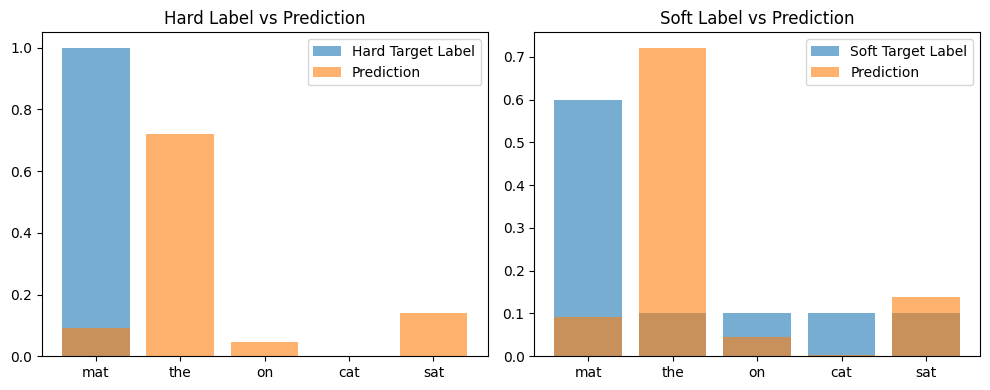

In [10]:
x_axis = np.arange(vocab_size)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(x_axis, np.eye(vocab_size)[hard_target_index], label='Hard Target Label', alpha=0.6)
plt.bar(x_axis, pred_probs, label='Prediction', alpha=0.6)
plt.xticks(x_axis, vocab)
plt.title("Hard Label vs Prediction")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x_axis, soft_target, label='Soft Target Label', alpha=0.6)
plt.bar(x_axis, pred_probs, label='Prediction', alpha=0.6)
plt.xticks(x_axis, vocab)
plt.title("Soft Label vs Prediction")
plt.legend()

plt.tight_layout()
plt.show()